In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.signal import fftconvolve
from bm3d import gaussian_kernel
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def get_experiment_kernel(noise_type: str, noise_var: float, sz: tuple = np.array((101, 101))):
    """
    Get kernel for generating noise from specific experiment from the paper.
    :param noise_type: Noise type string, g[0-4](w|)
    :param noise_var: noise variance
    :param sz: size of image, used only for g4 and g4w
    :return: experiment kernel with the l2-norm equal to variance
    """
    # if noiseType == gw / g0
    kernel = np.array([[1]])
    noise_types = ['gw', 'g0', 'g1', 'g2', 'g3', 'g4', 'g1w', 'g2w', 'g3w', 'g4w']
    if noise_type not in noise_types:
        raise ValueError("Noise type must be one of " + str(noise_types))

    if noise_type != "g4" and noise_type != "g4w":
        # Crop this size of kernel when generating,
        # unless pink noise, in which
        # if noiseType == we want to use the full image size
        sz = np.array([101, 101])
    else:
        sz = np.array(sz)

    # Sizes for meshgrids
    sz2 = -(1 - (sz % 2)) * 1 + np.floor(sz / 2)
    sz1 = np.floor(sz / 2)
    uu, vv = np.meshgrid([i for i in range(-int(sz1[0]), int(sz2[0]) + 1)],
                         [i for i in range(-int(sz1[1]), int(sz2[1]) + 1)])

    beta = 0.8

    if noise_type[0:2] == 'g1':
        # Horizontal line
        kernel = np.atleast_2d(16 - abs(np.linspace(1, 31, 31) - 16))

    elif noise_type[0:2] == 'g2':
        # Circular repeating pattern
        scale = 1
        dist = uu ** 2 + vv ** 2
        kernel = np.cos(np.sqrt(dist) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g3':
        # Diagonal line pattern kernel
        scale = 1
        kernel = np.cos((uu + vv) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g4':
        # Pink noise
        dist = uu ** 2 + vv ** 2
        n = sz[0] * sz[1]
        spec = (np.sqrt((np.sqrt(n) * 1e-2) / (np.sqrt(dist) + np.sqrt(n) * 1e-2)))
        kernel = fftshift(ifft2(ifftshift(spec)))

    else:  # gw and g0 are white
        beta = 0

    # -- Noise with additional white component --

    if len(noise_type) > 2 and noise_type[2] == 'w':
        kernel = kernel / np.sqrt(np.sum(kernel ** 2))
        kalpha = np.sqrt((1 - beta) + beta * abs(fft2(kernel, (sz[0], sz[1]))) ** 2)
        kernel = fftshift(ifft2(kalpha))

    kernel = np.real(kernel)
    # Correct variance
    kernel = kernel / np.sqrt(np.sum(kernel ** 2)) * np.sqrt(noise_var)

    return kernel

In [3]:
def get_experiment_noise(noise_type: str, noise_var: float, realization: int, sz: tuple)\
        -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Generate noise for experiment with specified kernel, variance, seed and size.
    Return noise and relevant parameters.
    The generated noise is non-circular.
    :param noise_type: Noise type, see get_experiment_kernel for list of accepted types.
    :param noise_var: Noise variance of the resulting noise
    :param realization: Seed for the noise realization
    :param sz: image size -> size of resulting noise
    :return: noise, PSD, and kernel
    """
    np.random.seed(realization)

    # Get pre-specified kernel
    kernel = get_experiment_kernel(noise_type, noise_var, sz)

    # Create noisy image
    half_kernel = np.ceil(np.array(kernel.shape) / 2)

    if len(sz) == 3 and half_kernel.size == 2:
        half_kernel = [half_kernel[0], half_kernel[1], 0]
        kernel = np.atleast_3d(kernel)

    half_kernel = np.array(half_kernel, dtype=int)

    # Crop edges
    # noise = fftconvolve(np.random.normal(size=(sz + 2 * half_kernel)), kernel, mode='same')
    noise = fftconvolve(np.random.normal(size=(sz + 2 * half_kernel)), kernel, mode='same')
    noise = np.atleast_3d(noise)[half_kernel[0]:-half_kernel[0], half_kernel[1]:-half_kernel[1], :]

    psd = abs(fft2(kernel, (sz[0], sz[1]), axes=(0, 1))) ** 2 * sz[0] * sz[1]

    return noise, psd, kernel

In [4]:
imagepath = 'dataset/dataset_structure'
imagename = imagepath + '/ref/1.png'
# Load noise-free image
image = Image.open(imagename).convert('L')
image = np.array(image)
print(image.shape)

(512, 512)


In [5]:
y = np.array(Image.open(imagename)) / 255
y.shape

(512, 512, 4)

TypeError: Invalid shape (512, 512, 512) for image data

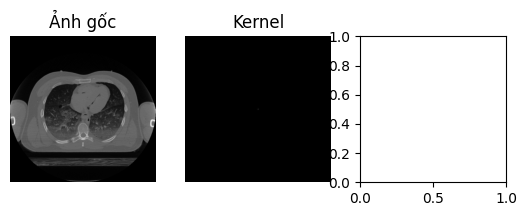

In [7]:
noise_type = 'g4w'
sigma = 25
noise_var = (sigma/255)**2  # Noise variance 25 std
seed = 0
sz = (512, 512)
noisy, _ ,kernel  = get_experiment_noise(noise_type, noise_var, seed, sz)
noisy_image = image + noisy
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Ảnh gốc')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kernel, cmap='gray')
plt.title('Kernel')
plt.axis('off')

# Hiển thị ảnh đã thêm nhiễu
plt.subplot(1, 3, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Ảnh đã thêm nhiễu')
plt.axis('off')

plt.show()